## Computing EERs Using Simple Threshold Analysis

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_FILES=glob.glob("data/*.csv")
THRESHOLDS=200
print(DATA_FILES)
sensor_frames = [pd.read_csv(file) for file in DATA_FILES]

['data/Accelerometer.csv', 'data/Light.csv', 'data/Gyroscope.csv', 'data/MagneticField.csv', 'data/LinearAcceleration.csv', 'data/RotationVector.csv', 'data/Gravity.csv']


In [18]:
def mae(a, b):
    """ Mean absolute error """
    return np.mean(np.abs(a - b))

def corr(a, b):
    """ Pearson's Correlation Coefficient """
    return np.corrcoef(a, b)[0,1]

def cross_corr(a, b):
    """ Cross correlation """
    return np.correlate(a, b)

def apply_metric(shared_group, f, d, key):
    """ Iterates each group of shared_group, applies
    similarity metric, f, and inserts into d[key] """
    for shared_id,group in shared_group:
        a,b = group.iloc[:,1:-1].as_matrix()
        try:
            c = f(a,b)
        except Exception:
            c = np.nan
        if not np.isnan(c):
            d[key].append(c)
    
def get_similarities(sensor_frame, f, i): 
    """ Compute similarity metrics for a given frame """
    # Group by legal and illegal transaction groups
    groups = sensor_frame.groupby("genuine_transaction")
    l_group = groups.get_group(1)
    i_group = groups.get_group(0)

    # Group by shared IDs for legal and illegal transactions
    l = l_group.groupby("shared_id")
    il = i_group.groupby("shared_id")
    
    # Apply metrics on +/- data
    data = {'0':[], '1':[]}
    apply_metric(l, f, data, '1')
    apply_metric(il, f, data, '0')
    return data


def compute_eer(negs, poss):
    """ Compute EER for given + and - labelled similarities """
    fprs, fnrs = [], []
    ts = np.linspace(min(min(negs), min(poss)), 
                     max(max(negs), max(poss)),
                     num=THRESHOLDS)
    for t in ts:
        fps, fns, tps, tns = 0, 0, 0, 0
        for n in negs:
            if n <= t:
                fps += 1                
            else:
                tns += 1
        for p in poss:
            if p <= t:
                tps += 1
            else:
                fns += 1
                
        # Store fpr,fnr for plotting graphs
        fpr = fps / (fps + tns); fprs.append(fpr);
        fnr = fns / (fns + tps); fnrs.append(fnr);
    eer_i = np.argwhere(np.isclose(fprs, fnrs, atol = 0.1, equal_nan=True)).reshape(-1)
    eer = np.median([fprs[int(np.median(eer_i))], fnrs[int(np.median(eer_i))]])
    t = ts[int(np.mean(eer_i))]
    return(fprs, fnrs, eer, t, ts)

def analyse(data):
    fprs, fnrs, eer, t, ts = compute_eer(data['1'], data['0'])
    print("EER:", eer, "t:",t)
    fig, ax = plt.subplots()
    ax.plot(ts, fprs, 'b--', label='FAR')
    ax.plot(ts, fnrs, 'r', label='FRR')
    ax.legend(loc=1)
    plt.show()

Analysing data/Accelerometer.csv
*** MAE ***
EER: 0.493523316062 t: 0.913255980199


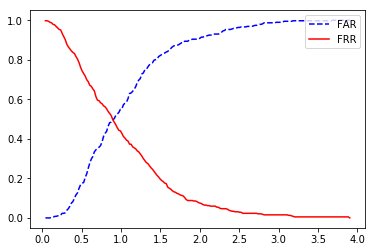

*** CORR ***
EER: 0.480569948187 t: 0.526198447707


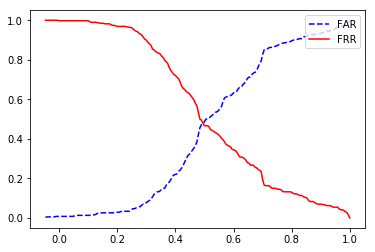

Analysing data/Light.csv
*** MAE ***
EER: 0.366925064599 t: 26.5481407035


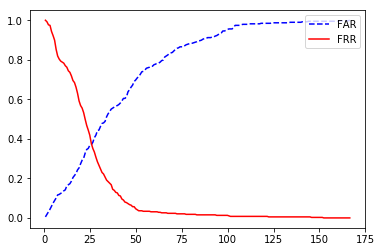

*** CORR ***
EER: 0.488 t: 0.714311778969


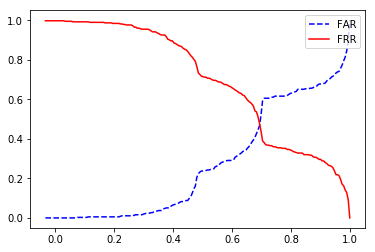

Analysing data/Gyroscope.csv
*** MAE ***
EER: 0.52135678392 t: 0.32880048671


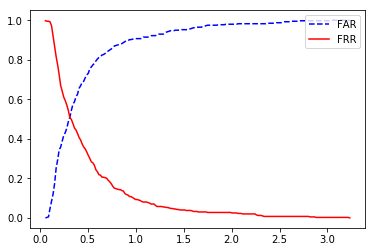

*** CORR ***
EER: 0.454773869347 t: 0.336343225966


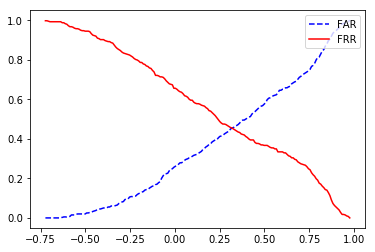

Analysing data/MagneticField.csv
*** MAE ***
EER: 0.443548387097 t: 153.866859193


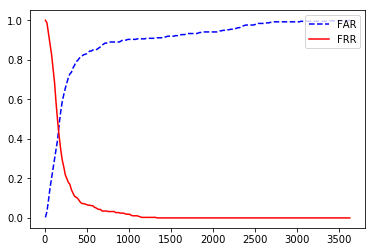

*** CORR ***
EER: 0.47311827957 t: 0.399341465206


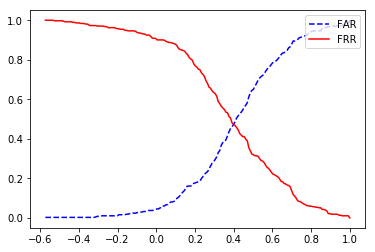

Analysing data/LinearAcceleration.csv
*** MAE ***
EER: 0.482252382926 t: 0.569463448193


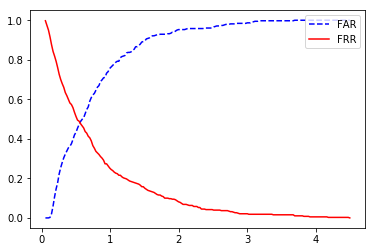

*** CORR ***
EER: 0.536113413455 t: 0.0646544567632


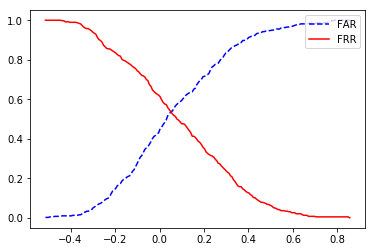

Analysing data/RotationVector.csv
*** MAE ***
EER: 0.329639889197 t: 0.492734989917


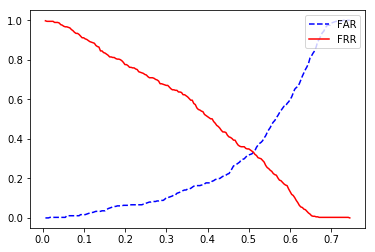

*** CORR ***
EER: 0.472299168975 t: 0.469806796484


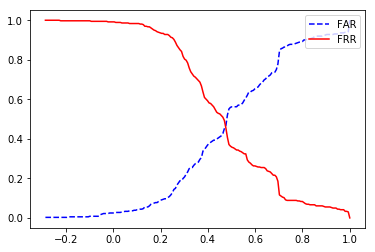

Analysing data/Gravity.csv
*** MAE ***
EER: 0.520742974012 t: 0.289764920235


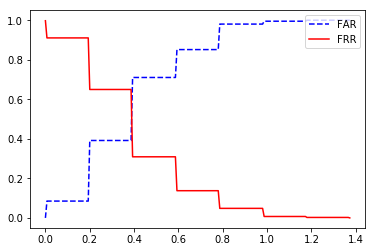

*** CORR ***
EER: 0.490011989139 t: 0.586267063029


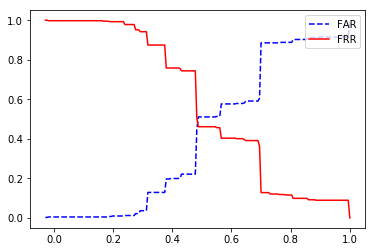

In [17]:
# Compute MAES and Corrs for each sensor frame
for i, sensor_frame in enumerate(sensor_frames):
    print("Analysing", DATA_FILES[i])
    maes = get_similarities(sensor_frame, mae, i)
    corrs = get_similarities(sensor_frame, corr, i)
    print("*** MAE ***")
    analyse(maes)
    print("*** CORR ***")
    analyse(corrs)